In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from scipy.sparse import load_npz
from node2vec import Node2Vec
import multiprocessing
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm

In [4]:
# Load all the saved features and models
df = pd.read_csv('ml_ready_data.csv')

final_dataset = load_npz('final_dataset.npz')

reduced_features = np.load('reduced_features.npy')

with open('citation_graph.gpickle', 'rb') as f:
    G = pickle.load(f)

with open('citation_graph_undirected.gpickle', 'rb') as f:
    G_undirected = pickle.load(f)

# Graph Embedding with Node2Vec

In [46]:
# List all connected components
connected_components = list(nx.connected_components(G_undirected))

# Get sizes of all components
component_sizes = [(len(c), c) for c in connected_components]

# Sort components by size in descending order
sorted_components = sorted(component_sizes, key=lambda x: x[0], reverse=True)

# Print sizes of the largest connected components
print("Sizes of the largest connected components:")
for size, _ in sorted_components[:10]:
    print(size)

Sizes of the largest connected components:
65
57
48
44
41
40
32
30
28
25


In [ ]:
# Desired number of nodes in the subgraph
desired_num_nodes = 5000 # try to increase this as much as possible

# Collect nodes from the largest components
nodes_to_include = set()
total_nodes = 0

for size, component in sorted_components:
    nodes_to_include.update(component)
    total_nodes += size
    if total_nodes >= desired_num_nodes:
        break

# Create the subgraph
G_sub = G_undirected.subgraph(nodes_to_include).copy()

print(f"Number of nodes in the subgraph: {G_sub.number_of_nodes()}")
print(f"Number of edges in the subgraph: {G_sub.number_of_edges()}")

Number of nodes in the subgraph: 5003
Number of edges in the subgraph: 4636


In [48]:
# Initialize Node2Vec model
node2vec = Node2Vec(
    G_sub,
    dimensions=64,
    walk_length=25,
    num_walks=50,
    workers=multiprocessing.cpu_count(),
    p = 1,
    q = 1
)

# Learn embeddings
with tqdm(desc="Learning Embeddings", total=1, colour="blue") as pbar:
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    pbar.update(1)

# Get embeddings for all nodes
node_embeddings = np.array([model.wv.get_vector(str(node)) for node in G_sub.nodes()])
node_ids = list(G_sub.nodes())

# Save embeddings
np.save('node_embeddings.npy', node_embeddings)
np.save('node_ids.npy', node_ids)

Computing transition probabilities:   0%|          | 0/5003 [00:00<?, ?it/s]

Generating walks (CPU: 49): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]
Generating walks (CPU: 51): 0it [00:00, ?it/s]
Generating walks (CPU: 50): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]
Generating walks (CPU: 52): 0it [00:00, ?it/s]
Generating walks (CPU: 53): 0it [00:00, ?it/s]
Generating walks (CPU: 54): 0it [00:00, ?it/s]
Generating walks (CPU: 55): 0it [00:00, ?it/s]
Generating walks (CPU: 56): 0it [00:00, ?it/s]
Generating walks (CPU: 57): 0it [00:00, ?it/s]
Generating walks (CPU: 58): 0it [00:00, ?it/s]
Generating walks (CPU: 59): 0it [00:00, ?it/s]
Generating walks (CPU: 60): 0it [00:00, ?it/s]
Generating walks (CPU: 61): 0it [00:00, ?it/s]
Generating walks (CPU: 62): 0it [00:00, ?it/s]
Generating walks (CPU: 63): 0it [00:00, ?it/s]
Generating walks (CPU: 64): 0it [00:00, ?it/s]
Learning Embeddings: 100%|██████████| 1/1 [04:32<00:00, 272.69s/it]


Elbow Method: 100%|██████████| 18/18 [00:00<00:00, 43.18it/s]


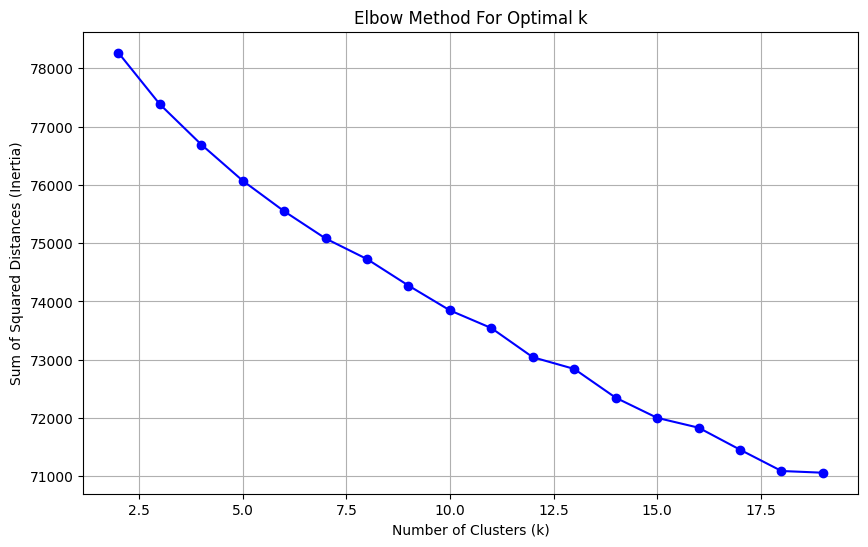

In [49]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

sum_of_squared_distances = []
K = range(2, 20)

for k in tqdm(K, desc='Elbow Method', colour='green'):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(node_embeddings)
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

Silhouette Analysis: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]


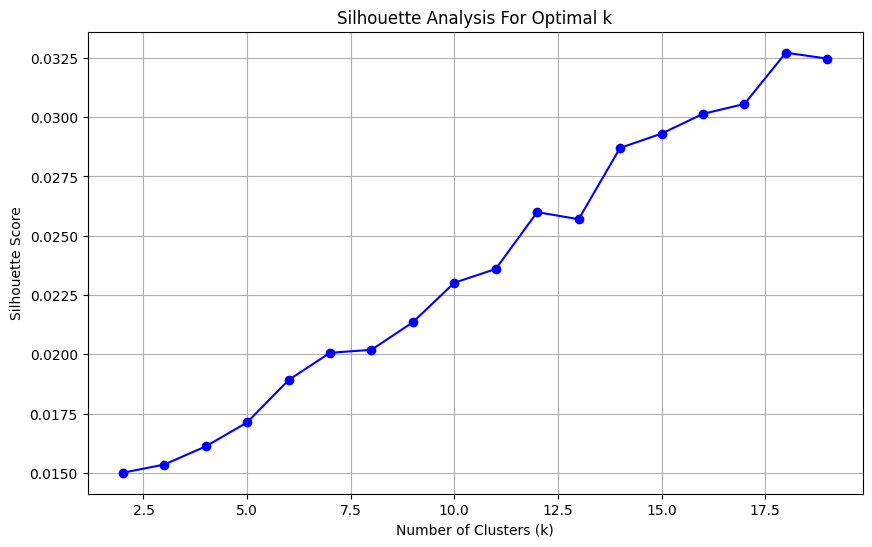

In [50]:
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []

for k in tqdm(K, desc='Silhouette Analysis', colour='green'):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(node_embeddings)
    score = silhouette_score(node_embeddings, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.grid(True)
plt.show()

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cluster the node embeddings
kmeans = KMeans(n_clusters=10, random_state=42)
node_labels = kmeans.fit_predict(node_embeddings)

# Evaluate clustering
score = silhouette_score(node_embeddings, node_labels)
print(f'Silhouette Score for Node2Vec embeddings: {score}')

# Save cluster labels
np.save('node2vec_kmeans_cluster_labels.npy', node_labels)

Silhouette Score for Node2Vec embeddings: 0.02301798202097416


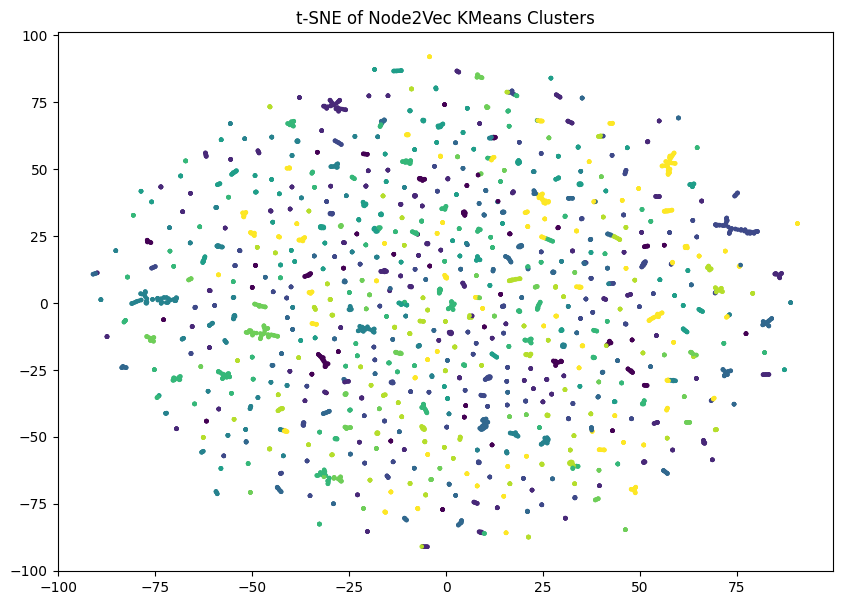

In [54]:
#visualization
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
node_tsne = tsne.fit_transform(node_embeddings)

plt.figure(figsize=(10, 7))
plt.scatter(node_tsne[:, 0], node_tsne[:, 1], c=node_labels, cmap='viridis', s=5)
plt.title('t-SNE of Node2Vec KMeans Clusters')
plt.show()

In [55]:
plt.savefig('tsne_node_clusters.png', dpi=300)

<Figure size 640x480 with 0 Axes>

# Graph Neural Networks

In [59]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Prepare node features and edge index
node_features = torch.tensor(node_embeddings, dtype=torch.float)
node_mapping = {node_id: idx for idx, node_id in enumerate(node_ids)}
edge_index = []

for edge in G_sub.edges():
    source = node_mapping[edge[0]]
    target = node_mapping[edge[1]]
    edge_index.append([source, target])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Create PyTorch Geometric data object
data = Data(x=node_features, edge_index=edge_index)

In [60]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [61]:
# Use clusters from Node2Vec as pseudo-labels
labels = torch.tensor(node_labels, dtype=torch.long)

In [62]:
from sklearn.model_selection import train_test_split

train_mask, test_mask = train_test_split(
    np.arange(len(labels)), test_size=0.2, random_state=42, stratify=labels
)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

In [63]:
model = GCN(num_features=node_features.shape[1], hidden_channels=64, num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
model.train()
for epoch in tqdm(range(200), desc='Training GCN', colour='green'):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()

Training GCN: 100%|██████████| 200/200 [00:01<00:00, 128.88it/s]


In [68]:
# Save the model
torch.save(model.state_dict(), 'gcn_node2vec.pth')

In [64]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[test_mask].eq(labels[test_mask]).sum().item())
accuracy = correct / len(test_mask)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9950


In [65]:
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

In [66]:
# Cluster the embeddings
kmeans = KMeans(n_clusters=10, random_state=42)
gcn_labels = kmeans.fit_predict(embeddings)

# Evaluate clustering
score = silhouette_score(embeddings, gcn_labels)
print(f'Silhouette Score for GCN embeddings: {score}')

# Save labels
np.save('gcn_cluster_labels.npy', gcn_labels)

Silhouette Score for GCN embeddings: 0.11881885677576065


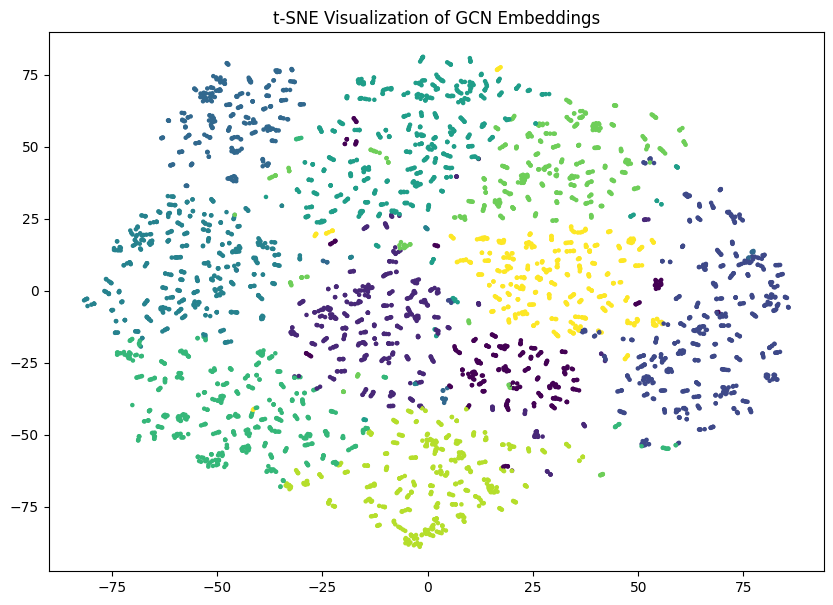

In [67]:
# Use t-SNE for visualization
tsne_results = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=gcn_labels, cmap='viridis', s=5)
plt.title('t-SNE Visualization of GCN Embeddings')
plt.show()

----------------------------------------------------------------------------------------------

In [ ]:
# TODO: Dimensionality reduction using auto encoders
# TODO: Graph attention networks